In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective
from VariationalBayes.Models.NormalMixture import normal_mixture as mix

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
num_obs = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
#true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)
true_mu = np.array([ np.linspace(-2., 2., k_num), np.linspace(-2., 2., k_num)]).T

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x, true_z, true_z_ind = mix.generate_data(num_obs, true_mu, true_sigma, true_pi)


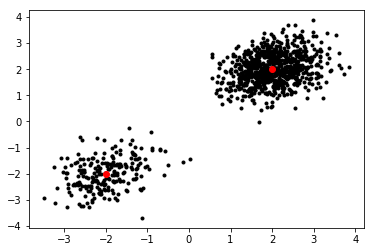

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [15]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(num_obs, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()
global_init_par_vec = params['global'].get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.71867953  0.99647742]
 [ 0.74865594  0.49913398]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [6]:
# weights = np.full((num_obs, 1), 1.0)
# e_z = params['local']['e_z'].get()
# get_multinoulli_entropy_hessian = autograd.hessian(mix.multinoulli_entropy)
# e_z0 = e_z[0, :]

# print(np.max(np.abs(
#     get_multinoulli_entropy_hessian(e_z0) - mix.get_sparse_multinoulli_entropy_hessian(e_z0).toarray())))

In [7]:
model = mix.Model(x, params, prior_params)
model.optimize_z()

kl_obj = SparseObjective(
    model.params, model.kl,
    fun_vector_local_hessian=model.kl_vector_local_hessian_sparse)

kl_obj_dense = Objective(model.params, model.kl)

kl_obj_global = Objective(model.params['global'], model.kl_optimal_z)


kl_obj_global.fun_free(model.params['global'].get_free())

4178.1843909229756

In [8]:
# # Sanity check
# nat_param_ad = model.get_z_nat_params(model.params['local']['e_z'].get())
# nat_param = model.loglik_obs_by_k()
# np.max(np.abs(nat_param - nat_param_ad))

In [9]:
# free_par = params.get_free()
# vec_par = params.get_vector()

# kl_obj.fun_free(free_par)
# grad = kl_obj.fun_free_grad_sparse(free_par)

# hvp_time = time.time()
# hvp = kl_obj.fun_free_hvp(free_par, grad)
# hvp_time = time.time() - hvp_time

# global_free_par = params['global'].get_free()
# local_free_par = params['local'].get_free()
# grad = kl_obj.fun_free_global_grad(global_free_par, local_free_par)
# hess = kl_obj.fun_free_global_hessian(global_free_par, local_free_par)

# # You can ignore the autograd warning.
# sparse_hess_time = time.time()
# sparse_hessian = kl_obj.fun_free_hessian_sparse(free_par)
# sparse_hess_time = time.time() - sparse_hess_time

# print('Sparse Hessian time: \t\t', sparse_hess_time)
# print('Hessian vector product time:\t', hvp_time)

# if True:
#     dense_hess_time = time.time()
#     dense_hessian = kl_obj_dense.fun_free_hessian(free_par)
#     dense_hess_time = time.time() - dense_hess_time

#     print('Dense Hessian time: \t\t', dense_hess_time)
#     print('Difference: ', np.max(np.abs(dense_hessian - sparse_hessian)))



In [10]:
# # Check the weight Jacobians.
# get_loglik_obs_free_local_jac = \
#     autograd.jacobian(model.loglik_obs_free_global_local, argnum=1)

# free_par_global = model.params['global'].get_free()
# free_par_local = model.params['local'].get_free()


# loglik_obs_free_local_jac = \
#     get_loglik_obs_free_local_jac(free_par_global, free_par_local)

# loglik_vector_local_weight_hessian_sparse = \
#     model.loglik_vector_local_weight_hessian_sparse()

# likelihood_by_obs_free_local_jac_sparse = \
#     model.loglik_free_local_weight_hessian_sparse()

# print(np.max(np.abs(loglik_obs_free_local_jac - likelihood_by_obs_free_local_jac_sparse)))


In [11]:
# # Perform EM.

# model.params.set_free(init_par_vec)
# model.optimize_z()
# global_param_vec = model.params['global'].get_vector()
# kl = model.kl()

# for step in range(20):
#     global_free_par = model.params['global'].get_free()
#     local_free_par = model.params['local'].get_free()
    
#     # Different choices for the M step:
#     global_vb_opt = optimize.minimize(
#        lambda par: kl_obj.fun_free_split(par, local_free_par),
#        x0=global_free_par,
#        jac=lambda par: kl_obj.fun_free_global_grad(par, local_free_par),
#        hess=lambda par: kl_obj.fun_free_global_hessian(par, local_free_par),
#        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
#     model.params['global'].set_free(global_vb_opt.x)

#     # E-step:
#     model.optimize_z()

#     new_global_param_vec = model.params['global'].get_vector()
#     diff = np.max(np.abs(new_global_param_vec - global_param_vec))
#     global_param_vec = deepcopy(new_global_param_vec)
    
#     new_kl = model.kl()
#     kl_diff = new_kl - kl
#     kl = new_kl
#     print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
#     if diff < 1e-6:
#         break

# em_free_par = model.params.get_free()
# print('Done.')


 kl: 1177.8980314867174		kl_diff = -2325.1942422433603		diff = 2.0027894074368997
 kl: 1170.1515606060366		kl_diff = -7.746470880680818		diff = 0.09089662525162612
 kl: 1142.3234700108856		kl_diff = -27.828090595151025		diff = 0.1751031303266114
 kl: 1033.5624434906651		kl_diff = -108.76102652022041		diff = 0.30141903274188
 kl: 725.8070175918903		kl_diff = -307.7554258987749		diff = 0.5271988899648821
 kl: 617.3456124928738		kl_diff = -108.46140509901647		diff = 0.6166405782783216
 kl: 589.6512679645161		kl_diff = -27.694344528357647		diff = 0.4469698821498257
 kl: 561.9840863533504		kl_diff = -27.667181611165688		diff = 0.3594527101547125
 kl: 514.9255510873935		kl_diff = -47.05853526595695		diff = 0.3363670316861447
 kl: 437.94689317835685		kl_diff = -76.97865790903666		diff = 0.3419716522177749
 kl: 417.7545786004279		kl_diff = -20.192314577928926		diff = 0.5350807170365424
 kl: 417.7538776616419		kl_diff = -0.0007009387859966409		diff = 0.004111748772515522
 kl: 417.7538776182392	

In [16]:
# # Newton is faster than CG if you go to high-quality optimum.
# vb_opt = optimize.minimize(
#     kl_obj.fun_free,
#     x0=em_free_par,
#     jac=kl_obj.fun_free_grad_sparse,
#     hess=kl_obj.fun_free_hessian_sparse,
#     method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

# print('done')
# print(kl_obj.fun_free(vb_opt.x))

em_global_free_par = model.params['global'].get_free()

vb_opt = optimize.minimize(
    kl_obj_global.fun_free,
    x0=global_init_par_vec,
    jac=kl_obj_global.fun_free_grad,
    hess=kl_obj_global.fun_free_hessian,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('done')
print(kl_obj_global.fun_free(vb_opt.x))

done
415.453906312


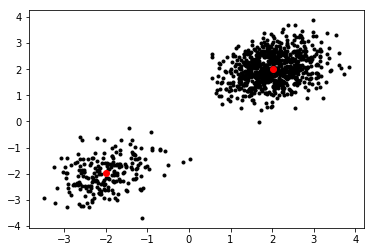

In [18]:
# Check that the solution looks sensible.
model.params['global'].set_free(vb_opt.x)
model.optimize_z()

mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [54]:
# from scipy.sparse import csc_matrix
# from scipy.sparse import csr_matrix

# moment_jac = model.get_moment_jacobian(vb_opt.x)

# kl_free_hessian_sparse = kl_obj.fun_free_hessian_sparse(vb_opt.x)
# sensitivity_operator = \
#     sp.sparse.linalg.spsolve(csc_matrix(kl_free_hessian_sparse),
#                              csr_matrix(moment_jac).T)

moment_jac = model.get_moment_jacobian(vb_opt.x)
kl_hessian = kl_obj_global.fun_free_hessian(vb_opt.x)
sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
print(sensitivity_operator.shape)

(11, 4)


In [50]:
model.params['global'].set_free(vb_opt.x)
global_vec = model.params['global'].get_vector()
local_vec = model.params['local'].get_vector()

def global_to_z(global_vec, model):
    model.params['global'].set_vector(global_vec)
    model.optimize_z()
    return model.params['local']['e_z'].get_vector()

eval_global_to_z_jac = autograd.jacobian(global_to_z)
global_to_z_jac = eval_global_to_z_jac(global_vec, model)
# weight_jac = model.loglik_free_weight_hessian_sparse()
# data_sens = (weight_jac.T * sensitivity_operator).toarray()
# print(data_sens.shape)

(2000, 12)


In [51]:
def loglik_obs_vector_global_local(vec_params_global, vec_params_local, model):
    model.params['global'].set_vector(vec_params_global)
    model.params['local'].set_vector(vec_params_local)
    return model.loglik_obs()

eval_loglik_obs_vector_global_local_hessian = autograd.jacobian(loglik_obs_vector_global_local, argnum=0)
loglik_vector_global_weight_hessian = eval_loglik_obs_vector_global_local_hessian(global_vec, local_vec, model)
loglik_vector_local_weight_hessian = model.loglik_vector_local_weight_hessian_sparse()



In [52]:
print(type(loglik_vector_global_weight_hessian))
print(type(loglik_vector_local_weight_hessian))
print(loglik_vector_global_weight_hessian.T.shape)
print(loglik_vector_local_weight_hessian.shape)
loglik_vector_weight_hessian = np.vstack(
    [loglik_vector_global_weight_hessian.T, loglik_vector_local_weight_hessian.toarray()])

global_to_global_z_jac = np.vstack([np.eye(len(global_vec)), global_to_z_jac])

loglik_vector_weight_hessian_global_only = np.matmul(global_to_global_z_jac.T, loglik_vector_weight_hessian)

<class 'numpy.ndarray'>
<class 'scipy.sparse.csr.csr_matrix'>
(12, 1000)
(2000, 1000)


In [55]:
print(loglik_vector_weight_hessian_global_only.shape)
loglik_vector_weight_free_global_only = model.params['global'].free_to_vector_jac(global_free_par)

(12, 1000)


<12x11 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in COOrdinate format>

In [61]:
def loglik_obs_set_z(global_free_par, model):
    model.params['global'].set_free(global_free_par)
    model.optimize_z()
    return model.loglik_obs()

eval_loglik_obs_set_z_jac = autograd.jacobian(loglik_obs_set_z)
weight_jac = eval_loglik_obs_set_z_jac(vb_opt.x, model)
data_sens = np.matmul(weight_jac, sensitivity_operator)
print(data_sens.shape)

(1000, 4)


In [63]:
rm_row = 1
keep_rows = np.setdiff1d(np.arange(model.x.shape[0]), rm_row)
model.params['global'].set_free(vb_opt.x)
model.optimize_z()

e_z_rm = vb.SimplexParam(name='e_z', shape=(num_obs - 1, k_num))
e_z_rm.set(model.params['local']['e_z'].get()[keep_rows, :])
rm_local = vb.ModelParamsDict('local')
rm_local.push_param(e_z_rm)

rm_params = vb.ModelParamsDict('mixture model deleted row')
rm_params.push_param(deepcopy(model.params['global']))
rm_params.push_param(rm_local)

rm_model = mix.Model(x[keep_rows, :], rm_params, prior_params)

In [69]:
# rm_model.kl_free(init_par)
# rm_model.kl_free_hessian_sparse(init_par)
# rm_kl_obj = SparseObjective(
#     rm_model.params, rm_model.kl,
#     fun_vector_local_hessian=rm_model.kl_vector_local_hessian_sparse)

rm_kl_obj = Objective(rm_model.params['global'], rm_model.kl_optimal_z)

init_par = model.params['global'].get_free()

#print(rm_model.kl_vector_local_hessian_sparse(global_vec, local_vec))
#print(rm_kl_obj.fun_vector_local_hessian(global_vec, local_vec))

#print(rm_kl_obj.fun_free_hessian_sparse(init_par))
rm_vb_opt = optimize.minimize(
    rm_kl_obj.fun_free,
    x0=init_par,
    jac=rm_kl_obj.fun_free_grad,
    hess=rm_kl_obj.fun_free_hessian,
    method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

print('Done')
rm_model.params['global'].set_free(rm_vb_opt.x)


Done


ValueError: Wrong size.

In [ ]:

print('Actual sensitivity:\t', 
      rm_model.get_interesting_moments(rm_vb_opt.x) - model.get_interesting_moments(vb_opt.x))
print('Predicted sensitivity:\t', -1 * data_sens[rm_row, :])
